In [8]:
import torch
import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import numpy as np

from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

# PYRO
[Getting started page](https://pyro.ai/examples/index.html)

## Model

Given some observations $x$, latent RV $z$, and paramenter $\theta$, the link between them is called (probabilistic) **model**, with pdf $$p_\theta(x,z)=p_\theta(x|z)p_\theta(z)$$
where $p_\theta(x|z)$ is the *likelihood*, $p_\theta(z)$ is the *prior*.

Things that we may be interested in are:
- inferring something about $z$ from data, i.e., the *posterior* $p_\theta(z|x)=\frac{p_\theta(x,z)}{\int dz p_\theta(x,z)}$
- how well the model describes data, i.e., the *marginal* $p_\theta(x)=\int dz p_\theta(x,z)$
- predict new data from the *posterior predictive distribution* $p_\theta(x'|x)=\int dz p_\theta(x'|z)p_\theta(z|x)$
- learning the parameter $\theta$ that best explain data, $\theta_\text{max}=\argmax_\theta p_\theta(x)$

Data $x$:

In [12]:
# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))
data = torch.tensor(data)

Below we define a model:

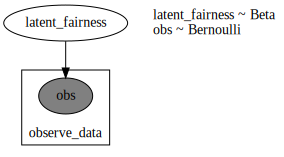

In [14]:
def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # vectorized plate over the observed data
    with pyro.plate('observe_data'):
        # likelihood Bernoulli(f)
        pyro.sample('obs', dist.Bernoulli(f), obs=data)

pyro.render_model(model, model_args=(data,), render_distributions=True)

Using plate tells Pyro that the observations are indipendent (conditioned on the latent variable), but it also allow to do subsampling. Notice that if data is on GPU, you should pass a "device" argument to plate.

## Guide
A **guide** is the variational distribution $q_\phi(z)$ that approximates the posterior $p_\theta(z|x)$. It does not contain data, unlike the model, but it must have all the latent variables that the model has (the correspondence is guaranteed by their **names**).

In [4]:
def guide(data):
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

Notice that the guide above doesn't have the "obs" RV, but it could have a "plate" in more complex scenarios.

## SVI
In order to do variational inference PYRO uses SVI class, which needs: a model, a guide and an optimizer.

In [6]:
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
losses = []
# do gradient steps
for step in range(n_steps):
    loss = svi.step(data) # step ensures that data is passed to both model and guide
    losses.append(loss)

    if step % 500 == 0:
        print(f"Loss: {loss}")

Loss: 7.032658100128174
Loss: 7.071733474731445
Loss: 7.062897801399231
Loss: 7.093270421028137
Loss: 7.069697618484497
Loss: 7.077534437179565
Loss: 7.073229670524597
Loss: 7.075173497200012
Loss: 7.040586233139038
Loss: 7.074746489524841


What did we learn?

In [9]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


Based on the data and our prior belief, the fairness of the coin is 0.537 +- 0.089


In this simple scenario we can analytically compute the true posterior using Bayes' theorem:
- The latent variable $z$ is defined within the model and its prior is a Beta distribution, i.e., $$p(z;\alpha,\beta)=\frac{1}{B(\alpha,\beta)}z^{\alpha-1}(1-z)^{\beta-1},$$ where $B(\alpha,\beta)$ is the normalizing factor.
- The likelihood is defined within the model as well and it's a Bernoulli, $p(x|z)=z^x(1-z)^{1-x}$.

So the true posterior is 
$$
\begin{align}
    p(z|x) &\propto \prod_{i=1}^N \, p(z;\alpha,\beta)p(x_i|z) \propto \\
        &\propto \prod_i \, z^{\alpha-1}(1-z)^{\beta-1}z^x_i(1-z)^{1-x_i} = \\
        &= z^{\alpha-1+\sum_i x_i}(1-z)^{N+\beta-1-\sum_i x_i} 
\end{align}
$$
which is again a Beta distribution (so our guide is not an _approximation_ of the true distribution, that explains why the loss doesn't really decrease much) with coefficients
$$
    \tilde{\alpha} = \alpha +\sum_{i=1}^N\,x_i = 10 + 6 = 16
$$
$$
    \tilde{\beta} = N + \beta - \sum_{i=1}^N\,x_i = 10 + 10 - 6 = 14
$$
which give
$$
    \text{mean} = \frac{\tilde{\alpha}}{\tilde{\alpha}+\tilde{\beta}} = \frac{16}{30} = 0.5\bar{3}
$$
$$
    \text{std} = \frac{1}{\tilde{\alpha}+\tilde{\beta}}\sqrt{\frac{\tilde{\alpha}\tilde{\beta}}{\tilde{\alpha}+\tilde{\beta}+1}} \simeq 0.09
$$
They are compatible with what found with SVI
$$
    \lambda = \frac{|0.5\bar{3}-0.537|}{\sqrt{0.089^2+0.09^2}} \simeq 0.03 < 1.
$$

In [11]:
# sum of x
sum = torch.tensor(data).sum()
print(sum)

tensor(6.)
